## Immporting Packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats.mstats import winsorize
import geopandas as gpd

## Importing Files

In [2]:
df_person_import = pd.read_csv("synthetic_persons.csv")
df_household_import = pd.read_csv("synthetic_households.csv")

In [3]:
shapefile_folder = '1270055001_sa2_2016_aust_shape\SA2_2016_AUST.shp'
australia = gpd.read_file(shapefile_folder)

In [4]:
df_person = df_person_import.copy()
df_household = df_household_import.copy()

# Displaying Area Covered By Data

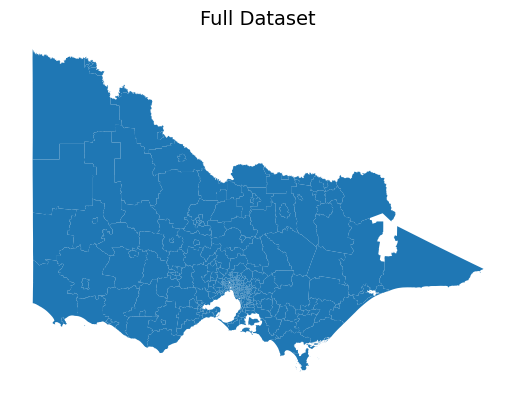

In [5]:
areas = pd.DataFrame({'SA2': df_household['SA2'].unique().astype(str)})
victoria_data = australia.merge(areas, left_on='SA2_MAIN16', right_on='SA2', how='inner').plot()
victoria_data.plot(title="All Data")
plt.title("Full Dataset", fontsize=14)
plt.axis('off')
plt.show()

## Reducing Area to Melbourne/Geelong

In [6]:
mel_gel = ('203', '213', '210', '210', '209', '214', '206', '207', '208', '211', '212')
df_household = df_household[df_household['SA2'].astype(str).str.startswith(mel_gel)]
df_person = df_person[df_person['SA2'].astype(str).str.startswith(mel_gel)]

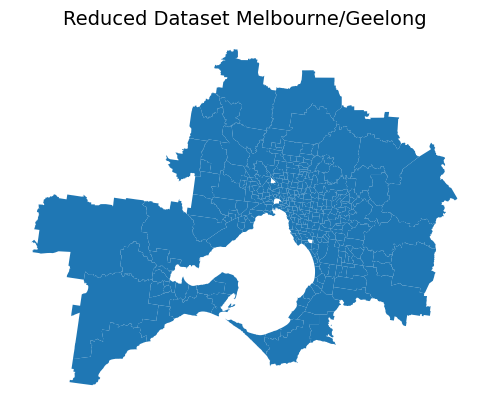

In [7]:

select = pd.DataFrame({'SA2': df_household['SA2'].unique()}).astype(str)
australia.merge(select, left_on='SA2_MAIN16', right_on='SA2', how='inner').plot()
plt.title("Reduced Dataset Melbourne/Geelong", fontsize=14)
plt.axis('off')
plt.show()

## Cleaning Data

In [8]:
ids = df_person[df_person['PERSINC'] == 'Missing/Refused']['household_id']

missing_values = ids.shape[0] / df_person.shape[0] * 100
print(f" Missing income entries {missing_values}%")

 Missing income entries 0.02291528755500253%


In [9]:
# Removing Missing data 
ids = df_person[df_person['PERSINC'] == 'Missing/Refused']['household_id']
df_person = df_person[~df_person['household_id'].isin(ids)]
df_household = df_household[~df_household['household_id'].isin(ids)]

In [10]:
# Converting Income string to numeric
lookup_table = {
    '$2000+ p.w.': 2000,
    '$1500-1999 p.w.': 1750,
    '$1250-1499 p.w.': 1375,
    '$1000-1249 p.w.': 1125,
    '$800-999 p.w.': 900,
    '$600-799 p.w.': 700,
    '$400-599 p.w.': 500,
    '$300-399 p.w.': 350,
    '$200-299 p.w.': 250,
    '$1-199 p.w.': 100,
    'Zero Income': 0,
    'Negative Income': -1,
    'Missing/Refused': None
}

df_person["INC"] = df_person["PERSINC"].replace(lookup_table)

# Summing total income for Household
total_inc = df_person.groupby('household_id')['INC'].sum()
df_household = df_household.merge(total_inc, on='household_id')
df_household.head()

,household_id,SA4,SA2,HHSIZE,TOTALVEHS,DWELLTYPE,OWNDWELL,INC
0,1,206,206011105,2,2,Separate House,Fully Owned,2350
1,2,206,206011105,2,1,Separate House,Being Purchased,800
2,3,206,206011105,2,1,Separate House,Being Purchased,800
3,4,206,206011105,2,2,Other,Being Purchased,4000
4,5,206,206011105,2,2,Other,Being Purchased,4000


In [11]:
# Creating age filter
children = df_person[df_person['AGE'] < 18].groupby('household_id').size().reset_index(name='children_count')
adults = df_person[df_person['AGE'] >= 30].groupby('household_id').size().reset_index(name='adults_count')

df_household = df_household.merge(children, on='household_id', how='left').fillna(0)
df_household = df_household.merge(adults, on='household_id', how='left').fillna(0)

#  Creating a variable to indicate if household fits age profile of less than 3 children and has an adult aged > 30
df_household['age_profile'] = np.where((df_household['adults_count'] > 1) & (df_household['children_count'] <= 2), 1, 0)
df_reduced = df_household[["household_id", "SA2", "HHSIZE", 'TOTALVEHS', 'DWELLTYPE', 'OWNDWELL', 'INC', 'age_profile']]
df_reduced.head()

,household_id,SA2,HHSIZE,TOTALVEHS,DWELLTYPE,OWNDWELL,INC,age_profile
0,1,206011105,2,2,Separate House,Fully Owned,2350,1
1,2,206011105,2,1,Separate House,Being Purchased,800,0
2,3,206011105,2,1,Separate House,Being Purchased,800,0
3,4,206011105,2,2,Other,Being Purchased,4000,1
4,5,206011105,2,2,Other,Being Purchased,4000,1


In [12]:
# Checking for any error by looking at unique values in the dataset
print(f"HHSIZE: {df_reduced['HHSIZE'].unique()}")
print(f"TOTALVEHS: {df_reduced['TOTALVEHS'].unique()}")
print(f"DWELLTYPE: {df_reduced['DWELLTYPE'].unique()}")
print(f"OWNDWELL: {df_reduced['OWNDWELL'].unique()}")
#print(f"INC: {df_reduced['INC'].unique()}")
print(f"age_profile: {df_reduced['age_profile'].unique()}")

HHSIZE: [2 4 3 1 5 7 8 9 6]
TOTALVEHS: [2 1 0 3 4 5 6 8 9 7]
DWELLTYPE: ['Separate House' 'Other' 'Flat or Apartment' 'Terrace/Townhouse']
OWNDWELL: ['Fully Owned' 'Being Purchased' 'Being Rented' 'Occupied Rent-Free'
 'Something Else']
age_profile: [1 0]


## Winsorizing Data

In [13]:
df_winsorize = df_reduced.copy()

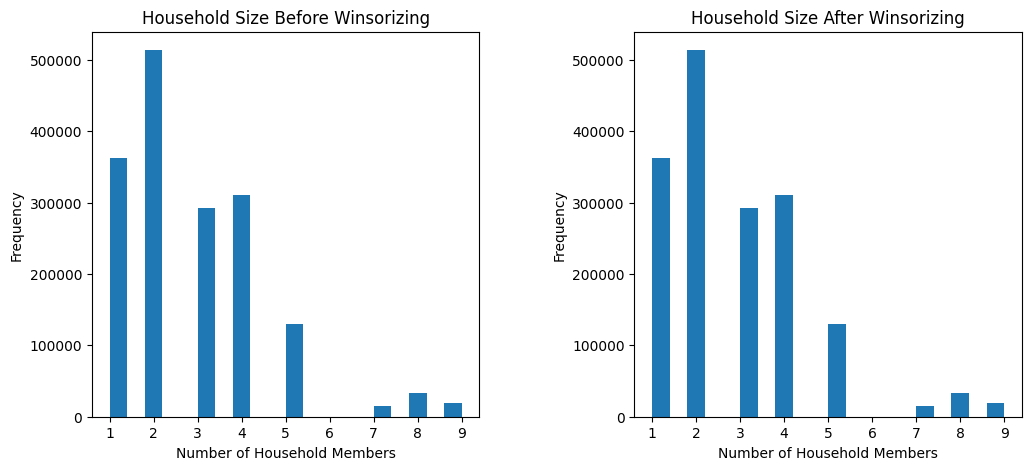

In [14]:
df_winsorize['HHSIZE'] = winsorize(df_reduced['HHSIZE'], limits=[0.01, 0.01])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.4)

axs[0].hist(df_reduced['HHSIZE'], bins=20)
axs[0].set_title('Household Size Before Winsorizing')
axs[0].set_xlabel('Number of Household Members')
axs[0].set_ylabel('Frequency')


axs[1].hist(df_winsorize['HHSIZE'], bins=20)
axs[1].set_title('Household Size After Winsorizing')
axs[1].set_xlabel('Number of Household Members')
axs[1].set_ylabel('Frequency')
plt.show()

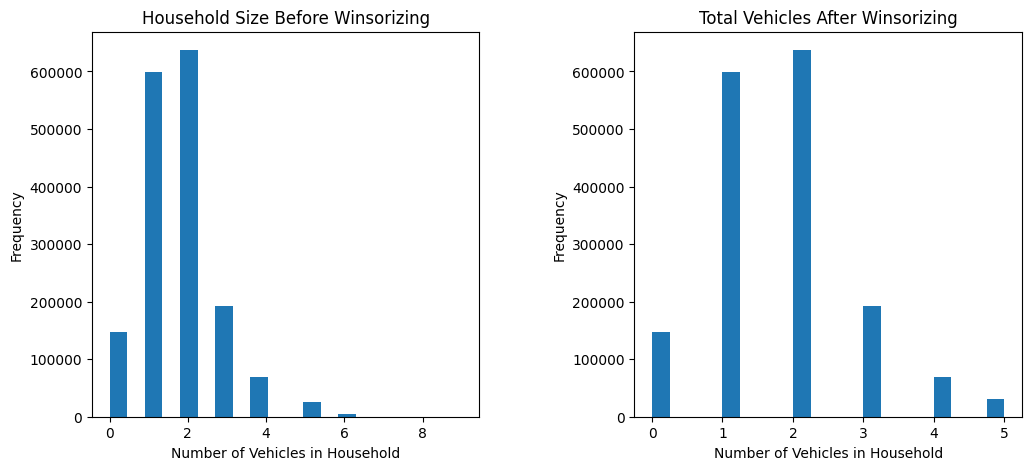

In [15]:
df_winsorize['TOTALVEHS'] = winsorize(df_reduced['TOTALVEHS'], limits=[0.01, 0.01])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.4)

axs[0].hist(df_reduced['TOTALVEHS'], bins=20)
axs[0].set_title('Household Size Before Winsorizing')
axs[0].set_xlabel('Number of Vehicles in Household')
axs[0].set_ylabel('Frequency')


axs[1].hist(df_winsorize['TOTALVEHS'], bins=20)
axs[1].set_title('Total Vehicles After Winsorizing')
axs[1].set_xlabel('Number of Vehicles in Household')
axs[1].set_ylabel('Frequency')
plt.show()

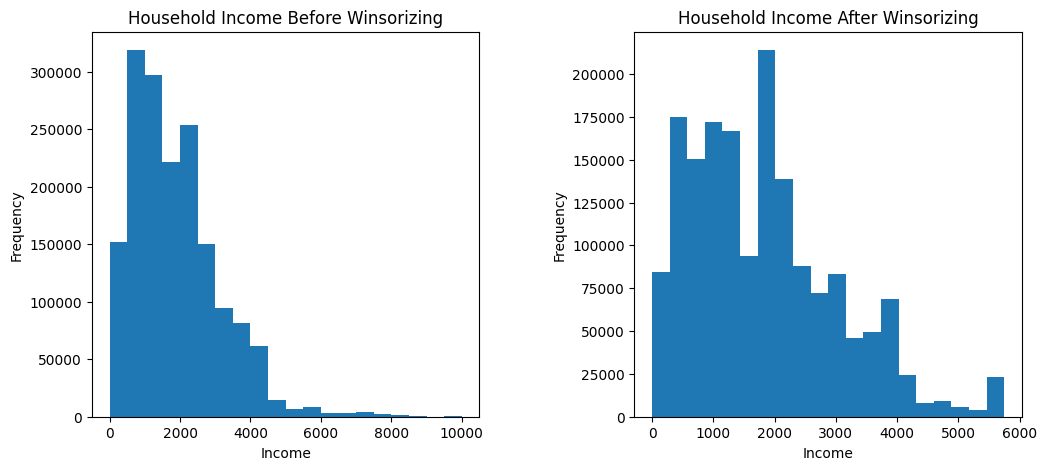

In [16]:

df_winsorize['INC'] = winsorize(df_reduced['INC'], limits=[0.01, 0.01])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.4)

axs[0].hist(df_reduced['INC'], bins=20)
axs[0].set_title('Household Income Before Winsorizing')
axs[0].set_xlabel('Income')
axs[0].set_ylabel('Frequency')


axs[1].hist(df_winsorize['INC'], bins=20)
axs[1].set_title('Household Income After Winsorizing')
axs[1].set_xlabel('Income')
axs[1].set_ylabel('Frequency')
plt.show()

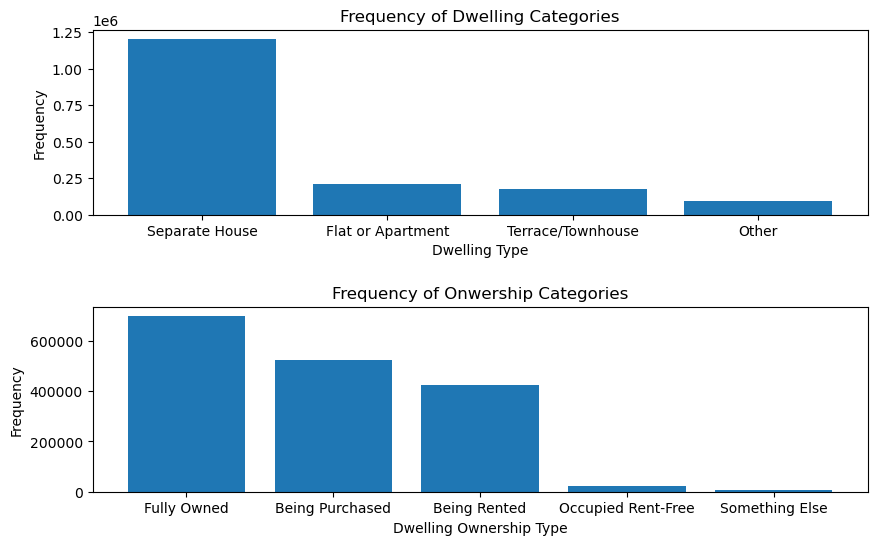

In [122]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.subplots_adjust(hspace=0.5)

# Plot for DWELLTYPE
axs[0].bar(df_winsorize['DWELLTYPE'].value_counts().index, df_winsorize['DWELLTYPE'].value_counts())
axs[0].set_xlabel('Dwelling Type')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency of Dwelling Categories')

# Plot for OWNDWELL
axs[1].bar(df_winsorize['OWNDWELL'].value_counts().index, df_winsorize['OWNDWELL'].value_counts())
axs[1].set_xlabel('Dwelling Ownership Type')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency of Onwership Categories')

plt.show()

## Normalise Data 

In [123]:
df_normalise= df_winsorize.copy()

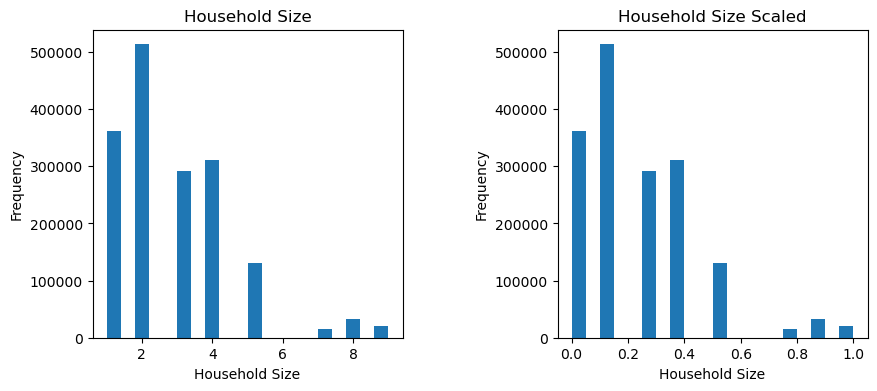

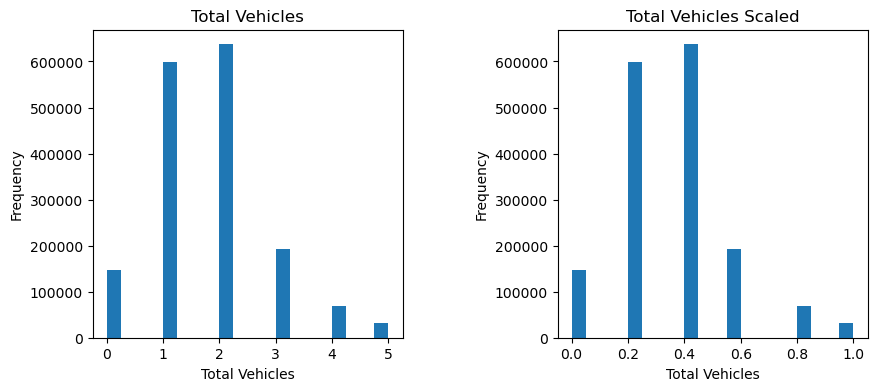

In [124]:
cols = ['HHSIZE', 'TOTALVEHS']
for col in cols:
    df_normalise[f'{col}_normalised'] = (df_normalise[col] - df_normalise[col].min()) / (df_normalise[col].max() - df_normalise[col].min())

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.5)
axs[0].hist(df_normalise['HHSIZE'], bins=20)
axs[0].set_title("Household Size")
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Household Size')

axs[1].hist(df_normalise['HHSIZE_normalised'], bins=20)
axs[1].set_title("Household Size Scaled")
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Household Size')
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.5)
axs[0].hist(df_normalise['TOTALVEHS'], bins=20)
axs[0].set_title("Total Vehicles")
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Total Vehicles')

axs[1].hist(df_normalise['TOTALVEHS_normalised'], bins=20)
axs[1].set_title("Total Vehicles Scaled")
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Total Vehicles')
plt.show()

In [125]:
qt = QuantileTransformer(output_distribution='uniform')
df_normalise['INC_normalised'] = qt.fit_transform(df_normalise[['INC']])

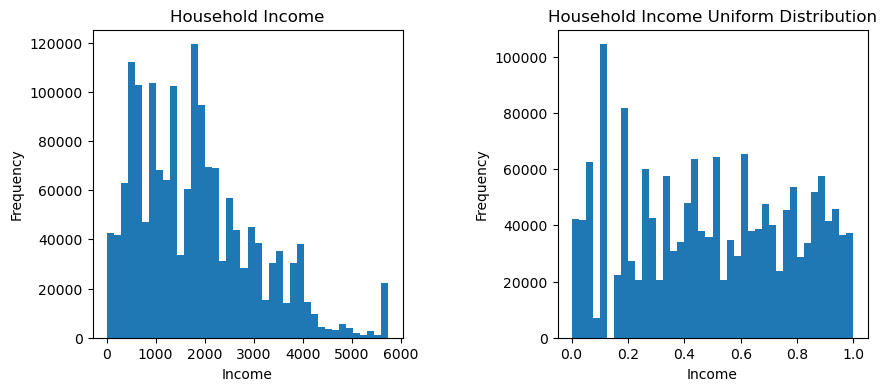

In [126]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.5)

axs[0].hist(df_normalise['INC'], bins=40)
axs[0].set_title("Household Income")
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Income')

axs[1].hist(df_normalise['INC_normalised'], bins=40)
axs[1].set_title("Household Income Uniform Distribution")
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Income')

plt.show()

In [127]:
df_normalise.head()

,household_id,SA2,HHSIZE,TOTALVEHS,DWELLTYPE,OWNDWELL,INC,age_profile,HHSIZE_normalised,TOTALVEHS_normalised,INC_normalised
0,1,206011105,2,2,Separate House,Fully Owned,2350,1,0.125,0.4,0.724725
1,2,206011105,2,1,Separate House,Being Purchased,800,0,0.125,0.2,0.219720
2,3,206011105,2,1,Separate House,Being Purchased,800,0,0.125,0.2,0.219720
3,4,206011105,2,2,Other,Being Purchased,4000,1,0.125,0.4,0.945946
4,5,206011105,2,2,Other,Being Purchased,4000,1,0.125,0.4,0.945946


# One Hot Encoding 

In [128]:
# Work with categorical data by using one hot encoding
df_onehot = df_normalise.copy()
df_onehot = pd.get_dummies(df_onehot, columns=['DWELLTYPE', 'OWNDWELL'])
df_onehot.head()

,household_id,SA2,HHSIZE,TOTALVEHS,INC,age_profile,HHSIZE_normalised,TOTALVEHS_normalised,INC_normalised,DWELLTYPE_Flat or Apartment,DWELLTYPE_Other,DWELLTYPE_Separate House,DWELLTYPE_Terrace/Townhouse,OWNDWELL_Being Purchased,OWNDWELL_Being Rented,OWNDWELL_Fully Owned,OWNDWELL_Occupied Rent-Free,OWNDWELL_Something Else
0,1,206011105,2,2,2350,1,0.125,0.4,0.724725,0,0,1,0,0,0,1,0,0
1,2,206011105,2,1,800,0,0.125,0.2,0.219720,0,0,1,0,1,0,0,0,0
2,3,206011105,2,1,800,0,0.125,0.2,0.219720,0,0,1,0,1,0,0,0,0
3,4,206011105,2,2,4000,1,0.125,0.4,0.945946,0,1,0,0,1,0,0,0,0
4,5,206011105,2,2,4000,1,0.125,0.4,0.945946,0,1,0,0,1,0,0,0,0


In [129]:
# Convert SA2 column to string
df_onehot['SA2'] = df_onehot['SA2'].astype(str)

In [130]:
df_onehot.to_csv('clean_data.csv', index=False)